Please Follow this Docker container installation process in your MacBook/Laptop before running this Python+R Notebook below.

  - Installation setup of environment where this notebook runs can be found i 
  Container with Jupyter+H2o.ai+Python3+R+Spark in this [link_here](https://github.com/jpacerqueira/project_lost_saturn)
  
  Also :
  - You need a Strong bandwith the install the Container environment it takes about 10-11 minutes to finish.
  
  - Good Luck,  stay safe! But investigate Corona virus(covid-19 or SARS-Cov-2) in your area and give the information back to the comunity!

  - Folium maps have custom Javascript and won't display in GitHub : https://stackoverflow.com/questions/53240378/folium-map-fail-to-render-in-notebook-on-github

# SparkSQL   -  Daily Analysis   -  Covid19 Sars-Cov2


###  COVID-19 SARS-COV2 - Daily Analysis


### Executed with data from John Hopkins inst. gituhub + my daily analysis notebooks


## Scrool to the bottom and look at the latest grafics

### 1.

###  Loading csv Daily Analysis file

In [1]:
#################################################################
###### Load The Daily JohnHopkins + 1Day Notebook Analysis ######
#################################################################
### Input date for analysis
anltdate="2020-12-06"
configs = {"analytics_date":anltdate}
#
### Input delta in folder :  /data
my_input_csv_table="World_v2--Confirmed-1Day_Forecast_--_train_"+anltdate+"-copy0.csv"
delta_location_covid19="file:///home/notebookuser/notebooks/data/delta_daily-covid19-global-analysis/dt="+anltdate
###
######
##############################Execution##########################
import findspark
findspark.init()
#
import pyspark
from pyspark.sql import functions as pfunc
from pyspark.sql import SQLContext
from pyspark.sql import Window, types
import re
import pandas as pd
import numpy as np
from pandas import DataFrame
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf
from pyspark.sql.functions import *
from scipy.stats import kstest
from scipy import stats
#
import subprocess
#
sc = pyspark.SparkContext(appName="Daily-Covid19-Global-Analysis")
sqlContext = SQLContext(sc)
#
#
internal_csv_files="file:///home/notebookuser/notebooks/covid19/data/"+my_input_csv_table
#
# Join with Internal Curation Data in urltopredict staged folder
from pyspark.sql import functions as F
### Scructure
from pyspark.sql.types import StructField,IntegerType,StructType,StringType,FloatType,DoubleType
newDF=[StructField('date',StringType(),True),
       StructField('region',StringType(),True),
       StructField('confirmed',StringType(),True),
       StructField('1_day_change',FloatType(),True),
       StructField('3_day_change',FloatType(),True),
       StructField('7_day_change',FloatType(),True),
       StructField('1_day_change_rate',DoubleType(),True),
       StructField('3_day_change_rate',DoubleType(),True),
       StructField('7_day_change_rate',DoubleType(),True),
       StructField('confirmed_yesterday',FloatType(),True),
       StructField('confirmed_prediction',FloatType(),True),
       StructField('population',FloatType(),True),
       StructField('infected_rate',DoubleType(),True),
       StructField('min',FloatType(),True),
       StructField('max',FloatType(),True),
       StructField('population_percentage_infected_rate_confirmed',DoubleType(),True),
       StructField('population_percentage_factor_9a10_infected_rate_confirmed',DoubleType(),True),
       StructField('delta_new_cases',FloatType(),True),
       StructField('delta_new_cases_per_1M_hab',FloatType(),True),
       StructField('delta_roling_7day_AVG',FloatType(),True),
       StructField('delta_aprox_14day_case_notification_rate_per_100k_hab',FloatType(),True)
       ]
finalStruct=StructType(fields=newDF)
#
dataframe_df1=sqlContext.read.csv(internal_csv_files,header="true",schema=finalStruct)\
.fillna("",subset=['date', 'region'])\
.fillna(0, subset=['1_day_change', '3_day_change', '7_day_change', 'confirmed_yesterday', 'confirmed_prediction', 'population', 'infected_rate', 'min', 'max', 'population_percentage_infected_rate_confirmed', 'population_percentage_factor_9a10_infected_rate_confirmed', 'population_percentage_factor_9a10_infected_rate_confirmed', 'delta_new_cases', 'delta_new_cases_per_1M_hab', 'delta_roling_7day_AVG', 'delta_aprox_14day_case_notification_rate_per_100k_hab'])\
.persist(pyspark.StorageLevel.MEMORY_AND_DISK_2)
#   
columns_to_drop = ['1_day_change_rate', '3_day_change_rate', '7_day_change_rate', 'infected_rate', 'min', 'max']
#
#dataframe_df1.printSchema()
dataframe_df1.drop(*columns_to_drop).show(5)
df2=dataframe_df1.drop(*columns_to_drop)
df2.write.mode('overwrite').format("delta").save(delta_location_covid19)
###
####
## sc.stop()
#
print("Data Load Done!")
#

+----------+---------------+---------+------------+------------+------------+-------------------+--------------------+----------+---------------------------------------------+---------------------------------------------------------+---------------+--------------------------+---------------------+-----------------------------------------------------+
|      date|         region|confirmed|1_day_change|3_day_change|7_day_change|confirmed_yesterday|confirmed_prediction|population|population_percentage_infected_rate_confirmed|population_percentage_factor_9a10_infected_rate_confirmed|delta_new_cases|delta_new_cases_per_1M_hab|delta_roling_7day_AVG|delta_aprox_14day_case_notification_rate_per_100k_hab|
+----------+---------------+---------+------------+------------+------------+-------------------+--------------------+----------+---------------------------------------------+---------------------------------------------------------+---------------+--------------------------+------------------

In [2]:
#sc.stop()
#exit()

### 2.


### Loading Data to Delta Lake for SparkSQL interrogations

In [3]:
##############################
###### Load The Delta   ######
##############################
###
### Input dates
#anltdate="2020-12-06"
#configs = {"analytics_date":anltdate}
#
### Input delta in folder :  /data
my_input_delta_table="delta_daily-covid19-global-analysis"
#
delta_table_name="covid19_jh_analysis"
###
######
##############################Execution##########################
import findspark
findspark.init()
#
import pyspark
from pyspark.sql import functions as pfunc
from pyspark.sql import SQLContext
from pyspark.sql import Window, types
import re
import pandas as pd
import numpy as np
from pandas import DataFrame
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf
from pyspark.sql.functions import *
from scipy.stats import kstest
from scipy import stats
#
import subprocess
3#
### CONTEXT required for 2nd,3rd,4th,5th runs
#
#sc = pyspark.SparkContext(appName="Daily-Covid19-Delta-Analysis")
#sqlContext = SQLContext(sc)
#
internal_delta_files="file:///home/notebookuser/notebooks/data/"+my_input_delta_table+"/dt="+anltdate
#
# Join with Internal Curation Data in urltopredict staged folder
from pyspark.sql import functions as F
delta_dataframe_df1=sqlContext.read.format("delta").load(internal_delta_files)\
.persist(pyspark.StorageLevel.MEMORY_AND_DISK_2)
#
## ,schema=finalStruct)\
## Py4JJavaError: An error occurred while calling o48.load.
## : org.apache.spark.sql.AnalysisException: delta does not allow user-specified schemas.;
##      	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:325)
#
delta_dataframe_df1.printSchema()
delta_dataframe_df1.registerTempTable(delta_table_name)
#
#
print("Delta table "+delta_table_name+" : registration Done!")
#

root
 |-- date: string (nullable = true)
 |-- region: string (nullable = true)
 |-- confirmed: string (nullable = true)
 |-- 1_day_change: float (nullable = true)
 |-- 3_day_change: float (nullable = true)
 |-- 7_day_change: float (nullable = true)
 |-- confirmed_yesterday: float (nullable = true)
 |-- confirmed_prediction: float (nullable = true)
 |-- population: float (nullable = true)
 |-- population_percentage_infected_rate_confirmed: double (nullable = true)
 |-- population_percentage_factor_9a10_infected_rate_confirmed: double (nullable = true)
 |-- delta_new_cases: float (nullable = true)
 |-- delta_new_cases_per_1M_hab: float (nullable = true)
 |-- delta_roling_7day_AVG: float (nullable = true)
 |-- delta_aprox_14day_case_notification_rate_per_100k_hab: float (nullable = true)

Delta table covid19_jh_analysis : registration Done!


### 3.

### Registering SQL functions as jupyter line_cell_magic

In [4]:
#
###### https://github.com/LucaCanali/Miscellaneous/blob/master/Pyspark_SQL_Magic_Jupyter/IPython_Pyspark_SQL_Magic.py
#
#
# IPython magic functions to use with Pyspark and Spark SQL
# The following code is intended as examples of shorcuts to simplify the use of SQL in pyspark
# The defined functions are:
#
# %sql <statement>          - return a Spark DataFrame for lazy evaluation of the SQL
# %sql_show <statement>     - run the SQL statement and show max_show_lines (50) lines
# %sql_display <statement>  - run the SQL statement and display the results using a HTML table 
#                           - this is implemented passing via Pandas and displays up to max_show_lines (50)
# %sql_explain <statement>  - display the execution plan of the SQL statement
#
# Use: %<magic> for line magic or %%<magic> for cell magic.
#
# Author: Luca.Canali@cern.ch
# September 2016
#

from IPython.core.magic import register_line_cell_magic

# Configuration parameters
max_show_lines = 80         # Limit on the number of lines to show with %sql_show and %sql_display
detailed_explain = True     # Set to False if you want to see only the physical plan when running explain

#### Joao - Fix - inject - AnalyticsData
##configs = {'analytics_date': << THE_DATE >> } #,"TABLE_NAME":"my_table","SCHEMA":"my_schema"}
### 

@register_line_cell_magic
def sql(line, cell=None):
    "Return a Spark DataFrame for lazy evaluation of the sql. Use: %sql or %%sql"
    val = cell if cell is not None else line 
    return sqlContext.sql(val.format(**configs))

@register_line_cell_magic
def sql_show(line, cell=None):
    "Execute sql and show the first max_show_lines lines. Use: %sql_show or %%sql_show"
    val = cell if cell is not None else line 
    return sqlContext.sql(val.format(**configs)).show(max_show_lines) 

@register_line_cell_magic
def sql_display(line, cell=None):
    """Execute sql and convert results to Pandas DataFrame for pretty display or further processing.
    Use: %sql_display or %%sql_display"""
    val = cell if cell is not None else line 
    return sqlContext.sql(val.format(**configs)).limit(max_show_lines).toPandas() 

@register_line_cell_magic
def sql_explain(line, cell=None):
    "Display the execution plan of the sql. Use: %sql_explain or %%sql_explain"
    val = cell if cell is not None else line 
    return sqlContext.sql(val.format(**configs)).explain(detailed_explain)
#

### 4.


### Validate SPARK-SQL instructions  %%sql_display  %%sql_explain %%sql_show

In [5]:
%%sql_display
select * from covid19_jh_analysis  order by date desc, region asc limit 5

,date,region,confirmed,1_day_change,3_day_change,7_day_change,confirmed_yesterday,confirmed_prediction,population,population_percentage_infected_rate_confirmed,population_percentage_factor_9a10_infected_rate_confirmed,delta_new_cases,delta_new_cases_per_1M_hab,delta_roling_7day_AVG,delta_aprox_14day_case_notification_rate_per_100k_hab
0,2020-12-06,Afghanistan_nan,0,235.0,354.0,1228.0,47072.0,47242.0,35530000.0,0.001325,0.013249,170.0,4.784689,175.428574,6.912468
1,2020-12-06,Albania_nan,0,846.0,2429.0,5358.0,42148.0,42810.0,2878445.0,0.014643,0.146430,662.0,229.985291,765.428589,372.284332
2,2020-12-06,Algeria_nan,0,772.0,2418.0,6290.0,87502.0,88531.0,41320000.0,0.002118,0.021177,1029.0,24.903194,898.571411,30.445305
3,2020-12-06,Andorra_nan,0,50.0,163.0,395.0,7005.0,7060.0,77239.0,0.090704,0.907043,55.0,712.075500,56.428570,1022.799377
4,2020-12-06,Angola_nan,0,43.0,217.0,449.0,15536.0,15604.0,32866272.0,0.000473,0.004727,68.0,2.068990,64.142860,2.732284


In [6]:
%%sql_display
select * from covid19_jh_analysis where region is not null and
    date >= {analytics_date} 
    order by date desc limit 5

,date,region,confirmed,1_day_change,3_day_change,7_day_change,confirmed_yesterday,confirmed_prediction,population,population_percentage_infected_rate_confirmed,population_percentage_factor_9a10_infected_rate_confirmed,delta_new_cases,delta_new_cases_per_1M_hab,delta_roling_7day_AVG,delta_aprox_14day_case_notification_rate_per_100k_hab


### 5.1.0


### The Regions in the World with +200  'notifications per 100k hab. in last 14days' and +10 cases a day AVG last 7days 

In [7]:
%%sql_display
select date,region,delta_roling_7day_AVG,delta_aprox_14day_case_notification_rate_per_100k_hab,
    1_day_change,3_day_change,7_day_change,confirmed_yesterday,
    population,population_percentage_factor_9a10_infected_rate_confirmed,
    delta_new_cases,delta_new_cases_per_1M_hab
    from covid19_jh_analysis where region is not null and
    date >= '2020-12-06' and
    delta_roling_7day_AVG >= 200 and
    delta_aprox_14day_case_notification_rate_per_100k_hab >= 10
order by delta_roling_7day_AVG desc, region asc
limit 60

,date,region,delta_roling_7day_AVG,delta_aprox_14day_case_notification_rate_per_100k_hab,1_day_change,3_day_change,7_day_change,confirmed_yesterday,population,population_percentage_factor_9a10_infected_rate_confirmed,delta_new_cases,delta_new_cases_per_1M_hab
0,2020-12-06,United States_nan,190948.000000,807.628601,213875.0,659424.0,1336636.0,14581337.0,3.310027e+08,0.440520,164421.0,496.736206
1,2020-12-06,Brazil_nan,40986.429688,269.953278,43209.0,140527.0,286905.0,6577177.0,2.125590e+08,0.309428,41194.0,193.800308
2,2020-12-06,India_nan,35900.429688,37.535923,36011.0,109258.0,251303.0,9644222.0,1.339000e+09,0.072026,36563.0,27.306198
3,2020-12-06,Turkey_nan,31363.714844,543.363464,31896.0,97013.0,219546.0,797893.0,8.081000e+07,0.098737,33060.0,409.107788
4,2020-12-06,Russia_nan,26708.857422,258.770935,28450.0,83357.0,186962.0,2410462.0,1.445000e+08,0.166814,25542.0,176.761246
5,2020-12-06,Italy_nan,20779.857422,481.015198,21052.0,68381.0,145459.0,1709991.0,6.048000e+07,0.282737,20667.0,341.716278
6,2020-12-06,Germany_nan,18735.142578,316.816040,26126.0,65687.0,131146.0,1183640.0,8.279000e+07,0.142969,15993.0,193.175507
7,2020-12-06,United Kingdom_nan,14399.857422,303.428650,15539.0,46715.0,100799.0,1705971.0,6.644000e+07,0.256769,13486.0,202.980133
8,2020-12-06,Ukraine_nan,13450.142578,430.031250,14157.0,44425.0,94151.0,822985.0,4.378798e+07,0.187948,13192.0,301.269897
9,2020-12-06,Iran_nan,13312.428711,221.892303,12151.0,39414.0,93187.0,1028986.0,8.399300e+07,0.122509,14176.0,168.775970


In [8]:
%%sql_display
select date,region,delta_roling_7day_AVG,delta_aprox_14day_case_notification_rate_per_100k_hab,
    1_day_change,3_day_change,7_day_change,confirmed_yesterday,
    population,population_percentage_factor_9a10_infected_rate_confirmed,
    delta_new_cases,delta_new_cases_per_1M_hab
    from covid19_jh_analysis where region is not null and
    date >= '2020-12-06' and
    delta_roling_7day_AVG >= 200 and
    delta_aprox_14day_case_notification_rate_per_100k_hab >= 80
order by delta_roling_7day_AVG desc, region asc

,date,region,delta_roling_7day_AVG,delta_aprox_14day_case_notification_rate_per_100k_hab,1_day_change,3_day_change,7_day_change,confirmed_yesterday,population,population_percentage_factor_9a10_infected_rate_confirmed,delta_new_cases,delta_new_cases_per_1M_hab
0,2020-12-06,United States_nan,190948.000000,807.628601,213875.0,659424.0,1336636.0,14581337.0,331002656.0,0.440520,164421.0,496.736206
1,2020-12-06,Brazil_nan,40986.429688,269.953278,43209.0,140527.0,286905.0,6577177.0,212559008.0,0.309428,41194.0,193.800308
2,2020-12-06,Turkey_nan,31363.714844,543.363464,31896.0,97013.0,219546.0,797893.0,80810000.0,0.098737,33060.0,409.107788
3,2020-12-06,Russia_nan,26708.857422,258.770935,28450.0,83357.0,186962.0,2410462.0,144500000.0,0.166814,25542.0,176.761246
4,2020-12-06,Italy_nan,20779.857422,481.015198,21052.0,68381.0,145459.0,1709991.0,60480000.0,0.282737,20667.0,341.716278
5,2020-12-06,Germany_nan,18735.142578,316.816040,26126.0,65687.0,131146.0,1183640.0,82790000.0,0.142969,15993.0,193.175507
6,2020-12-06,United Kingdom_nan,14399.857422,303.428650,15539.0,46715.0,100799.0,1705971.0,66440000.0,0.256769,13486.0,202.980133
7,2020-12-06,Ukraine_nan,13450.142578,430.031250,14157.0,44425.0,94151.0,822985.0,43787980.0,0.187948,13192.0,301.269897
8,2020-12-06,Iran_nan,13312.428711,221.892303,12151.0,39414.0,93187.0,1028986.0,83993000.0,0.122509,14176.0,168.775970
9,2020-12-06,Poland_nan,11525.713867,424.855194,12427.0,40526.0,80680.0,1054273.0,37980000.0,0.277587,11012.0,289.942078


### 5.1.1


### The Regions in the World with +240  'notifications per 100k hab. in last 14days' and +300 cases AVG last 7days

In [9]:
%%sql_display
select date,region,delta_roling_7day_AVG,delta_aprox_14day_case_notification_rate_per_100k_hab,
    1_day_change,3_day_change,7_day_change,confirmed_yesterday,
    population,population_percentage_factor_9a10_infected_rate_confirmed,
    delta_new_cases,delta_new_cases_per_1M_hab
    from covid19_jh_analysis where region is not null and
    date >= '2020-12-06' and
    delta_roling_7day_AVG >= 300 and
    delta_aprox_14day_case_notification_rate_per_100k_hab >= 240
order by delta_roling_7day_AVG desc, region asc
limit 80

,date,region,delta_roling_7day_AVG,delta_aprox_14day_case_notification_rate_per_100k_hab,1_day_change,3_day_change,7_day_change,confirmed_yesterday,population,population_percentage_factor_9a10_infected_rate_confirmed,delta_new_cases,delta_new_cases_per_1M_hab
0,2020-12-06,United States_nan,190948.000000,807.628601,213875.0,659424.0,1336636.0,14581337.0,331002656.0,0.440520,164421.0,496.736206
1,2020-12-06,Brazil_nan,40986.429688,269.953278,43209.0,140527.0,286905.0,6577177.0,212559008.0,0.309428,41194.0,193.800308
2,2020-12-06,Turkey_nan,31363.714844,543.363464,31896.0,97013.0,219546.0,797893.0,80810000.0,0.098737,33060.0,409.107788
3,2020-12-06,Russia_nan,26708.857422,258.770935,28450.0,83357.0,186962.0,2410462.0,144500000.0,0.166814,25542.0,176.761246
4,2020-12-06,Italy_nan,20779.857422,481.015198,21052.0,68381.0,145459.0,1709991.0,60480000.0,0.282737,20667.0,341.716278
5,2020-12-06,Germany_nan,18735.142578,316.816040,26126.0,65687.0,131146.0,1183640.0,82790000.0,0.142969,15993.0,193.175507
6,2020-12-06,United Kingdom_nan,14399.857422,303.428650,15539.0,46715.0,100799.0,1705971.0,66440000.0,0.256769,13486.0,202.980133
7,2020-12-06,Ukraine_nan,13450.142578,430.031250,14157.0,44425.0,94151.0,822985.0,43787980.0,0.187948,13192.0,301.269897
8,2020-12-06,Poland_nan,11525.713867,424.855194,12427.0,40526.0,80680.0,1054273.0,37980000.0,0.277587,11012.0,289.942078
9,2020-12-06,Colombia_nan,8948.000000,246.763809,9642.0,28160.0,62636.0,1362249.0,50765952.0,0.268339,8633.0,170.054916


### 5.1.2


### The Regions in the World with +120  'notifications per 100k hab. in last 14days' and +300 cases AVG last 7days

In [10]:
%%sql_display
select date,region, delta_roling_7day_AVG, delta_aprox_14day_case_notification_rate_per_100k_hab,
    1_day_change,3_day_change,7_day_change,confirmed_yesterday,
    population,population_percentage_factor_9a10_infected_rate_confirmed,
    delta_new_cases,delta_new_cases_per_1M_hab
    from covid19_jh_analysis where region is not null and
    date >= '2020-12-06' and
    delta_roling_7day_AVG >= 300 and
    delta_aprox_14day_case_notification_rate_per_100k_hab >= 120 and 
    delta_aprox_14day_case_notification_rate_per_100k_hab < 240
order by delta_roling_7day_AVG desc, region asc
limit 80

,date,region,delta_roling_7day_AVG,delta_aprox_14day_case_notification_rate_per_100k_hab,1_day_change,3_day_change,7_day_change,confirmed_yesterday,population,population_percentage_factor_9a10_infected_rate_confirmed,delta_new_cases,delta_new_cases_per_1M_hab
0,2020-12-06,Iran_nan,13312.428711,221.892303,12151.0,39414.0,93187.0,1028986.0,83993000.0,0.122509,14176.0,168.775970
1,2020-12-06,France_nan,10299.713867,206.023712,12850.0,36618.0,72098.0,2279869.0,69990000.0,0.325742,8733.0,124.774971
2,2020-12-06,Argentina_nan,6636.714355,205.987137,5201.0,19729.0,46457.0,1459832.0,45106700.0,0.323640,7712.0,170.972382
3,2020-12-06,Morocco_nan,3864.285645,146.942474,4118.0,12548.0,27050.0,376738.0,36817128.0,0.102327,3775.0,102.533798
4,2020-12-06,Canada_Ontario,1782.857178,171.310913,1867.0,5358.0,12480.0,128997.0,14570000.0,0.088537,1735.0,119.080299
5,2020-12-06,Greece_nan,1647.714233,214.785843,1383.0,4913.0,11534.0,114568.0,10740000.0,0.106675,1901.0,177.001862
6,2020-12-06,Israel_nan,1274.000000,204.729111,1725.0,3858.0,8918.0,343826.0,8712000.0,0.394659,1067.0,122.474747
7,2020-12-06,United Arab Emirates_nan,1253.428589,186.680847,1214.0,3842.0,8774.0,175276.0,9400000.0,0.186465,1272.0,135.319153
8,2020-12-06,Tunisia_nan,1144.428589,135.872147,1091.0,3711.0,8011.0,102991.0,11791968.0,0.087341,886.0,75.135887
9,2020-12-06,Paraguay_nan,868.857117,171.043243,714.0,2731.0,6082.0,87213.0,7111652.0,0.122635,928.0,130.490082


### 5.1.3


### The Regions in the World with +80  'notifications per 100k hab. in last 14days' and +200 cases AVG last 7days

In [11]:
%%sql_display
select date,region, delta_roling_7day_AVG, delta_aprox_14day_case_notification_rate_per_100k_hab,
    1_day_change,3_day_change,7_day_change,confirmed_yesterday,
    population,population_percentage_factor_9a10_infected_rate_confirmed,
    delta_new_cases,delta_new_cases_per_1M_hab
    from covid19_jh_analysis where region is not null and
    date >= '2020-12-06' and
    delta_roling_7day_AVG >= 200 and
    delta_aprox_14day_case_notification_rate_per_100k_hab >= 80 and
    delta_aprox_14day_case_notification_rate_per_100k_hab <= 120
order by delta_roling_7day_AVG desc, region asc
limit 80

,date,region,delta_roling_7day_AVG,delta_aprox_14day_case_notification_rate_per_100k_hab,1_day_change,3_day_change,7_day_change,confirmed_yesterday,population,population_percentage_factor_9a10_infected_rate_confirmed,delta_new_cases,delta_new_cases_per_1M_hab
0,2020-12-06,Mexico_nan,9570.286133,104.153587,11625.0,34782.0,66992.0,1168395.0,128640792.0,0.090826,8956.0,69.620216
1,2020-12-06,South Africa_nan,3615.714355,85.580956,4645.0,13977.0,25310.0,810449.0,59148672.0,0.137019,2632.0,44.498039
2,2020-12-06,Chile_nan,1389.571411,101.954758,1533.0,4770.0,9727.0,558668.0,19081012.0,0.292788,1236.0,64.776436
3,2020-12-06,Dominican Republic_nan,714.571411,92.420021,975.0,2458.0,5002.0,147655.0,10824494.0,0.136409,603.0,55.706993
4,2020-12-06,Finland_nan,415.857147,105.604935,460.0,1336.0,2911.0,27218.0,5513000.0,0.049372,450.0,81.625252
5,2020-12-06,Kyrgyzstan_nan,400.428558,85.926308,401.0,1261.0,2803.0,74774.0,6524195.0,0.114612,322.0,49.354748
6,2020-12-06,Norway_nan,361.000000,94.343849,272.0,1104.0,2527.0,38073.0,5357000.0,0.071073,410.0,76.535378
7,2020-12-06,Ireland_nan,286.571442,81.447426,457.0,882.0,2006.0,73948.0,4925877.0,0.150123,174.0,35.323658
8,2020-12-06,Kuwait_nan,281.285706,95.189751,247.0,904.0,1969.0,144164.0,4137000.0,0.348477,297.0,71.791153
9,2020-12-06,Uruguay_nan,207.714279,83.776268,234.0,740.0,1454.0,6965.0,3471150.0,0.020068,173.0,49.839390


### 5.2


### The Regions in the World in analysis (population not dummy 10M) but with lower cases than above

In [12]:
%%sql_display
select date,region, delta_roling_7day_AVG, delta_aprox_14day_case_notification_rate_per_100k_hab,
    1_day_change,3_day_change,7_day_change,confirmed_yesterday,
    population,population_percentage_factor_9a10_infected_rate_confirmed,
    delta_new_cases,delta_new_cases_per_1M_hab
    from covid19_jh_analysis where region is not null and
    date >= '2020-12-06' and
    delta_roling_7day_AVG < 200 and
    delta_aprox_14day_case_notification_rate_per_100k_hab < 80 and
    population not in (10000000.0 )
    order by delta_roling_7day_AVG desc, region asc
limit 60

,date,region,delta_roling_7day_AVG,delta_aprox_14day_case_notification_rate_per_100k_hab,1_day_change,3_day_change,7_day_change,confirmed_yesterday,population,population_percentage_factor_9a10_infected_rate_confirmed,delta_new_cases,delta_new_cases_per_1M_hab
0,2020-12-06,El Salvador_nan,187.571426,40.485924,0.0,588.0,1313.0,39718.0,6486205.0,0.061236,236.0,36.384911
1,2020-12-06,Afghanistan_nan,175.428574,6.912468,235.0,354.0,1228.0,47072.0,35530000.0,0.013249,170.0,4.784689
2,2020-12-06,Uzbekistan_nan,147.571426,6.192386,0.0,416.0,1033.0,73751.0,33363556.0,0.022106,201.0,6.024538
3,2020-12-06,Mauritania_nan,128.714279,38.755539,178.0,496.0,901.0,9359.0,4649658.0,0.020131,79.0,16.990498
4,2020-12-06,Bolivia_nan,128.571426,15.352940,167.0,498.0,900.0,145492.0,11724139.0,0.124097,103.0,8.785294
5,2020-12-06,Zimbabwe_nan,113.571426,10.697761,70.0,488.0,795.0,10617.0,14862924.0,0.007144,137.0,9.217567
6,2020-12-06,Ghana_nan,102.428574,4.636118,0.0,429.0,717.0,52096.0,30931048.0,0.016843,72.0,2.327758
7,2020-12-06,China_Hong Kong,97.000000,18.371212,101.0,303.0,679.0,6802.0,7392000.0,0.009203,90.0,12.175324
8,2020-12-06,Cameroon_nan,90.714287,4.811644,0.0,265.0,635.0,24752.0,26394308.0,0.009378,94.0,3.561374
9,2020-12-06,Syria_nan,86.428574,6.914026,87.0,261.0,605.0,8320.0,17500658.0,0.004755,87.0,4.971241


In [13]:
%%sql_display
select date,region, delta_roling_7day_AVG, delta_aprox_14day_case_notification_rate_per_100k_hab,
    1_day_change,3_day_change,7_day_change,confirmed_yesterday,
    population,population_percentage_factor_9a10_infected_rate_confirmed,
    delta_new_cases,delta_new_cases_per_1M_hab
    from covid19_jh_analysis where region is not null and
    date >= '2020-12-06' and
    delta_roling_7day_AVG < 200 and
    delta_aprox_14day_case_notification_rate_per_100k_hab < 80 and
    population not in (10000000.0 )
    order by delta_roling_7day_AVG desc, region asc

,date,region,delta_roling_7day_AVG,delta_aprox_14day_case_notification_rate_per_100k_hab,1_day_change,3_day_change,7_day_change,confirmed_yesterday,population,population_percentage_factor_9a10_infected_rate_confirmed,delta_new_cases,delta_new_cases_per_1M_hab
0,2020-12-06,El Salvador_nan,187.571426,40.485924,0.0,588.0,1313.0,39718.0,6486205.0,0.061236,236.0,36.384911
1,2020-12-06,Afghanistan_nan,175.428574,6.912468,235.0,354.0,1228.0,47072.0,35530000.0,0.013249,170.0,4.784689
2,2020-12-06,Uzbekistan_nan,147.571426,6.192386,0.0,416.0,1033.0,73751.0,33363556.0,0.022106,201.0,6.024538
3,2020-12-06,Mauritania_nan,128.714279,38.755539,178.0,496.0,901.0,9359.0,4649658.0,0.020131,79.0,16.990498
4,2020-12-06,Bolivia_nan,128.571426,15.352940,167.0,498.0,900.0,145492.0,11724139.0,0.124097,103.0,8.785294
5,2020-12-06,Zimbabwe_nan,113.571426,10.697761,70.0,488.0,795.0,10617.0,14862924.0,0.007144,137.0,9.217567
6,2020-12-06,Ghana_nan,102.428574,4.636118,0.0,429.0,717.0,52096.0,30931048.0,0.016843,72.0,2.327758
7,2020-12-06,China_Hong Kong,97.000000,18.371212,101.0,303.0,679.0,6802.0,7392000.0,0.009203,90.0,12.175324
8,2020-12-06,Cameroon_nan,90.714287,4.811644,0.0,265.0,635.0,24752.0,26394308.0,0.009378,94.0,3.561374
9,2020-12-06,Syria_nan,86.428574,6.914026,87.0,261.0,605.0,8320.0,17500658.0,0.004755,87.0,4.971241


### 6.


### Regions out of model where ratios requiring model view may require data in population.csv

In [14]:
%%sql_display
select * from covid19_jh_analysis where region is not null and
    date >= '2020-12-06' and
    delta_roling_7day_AVG >= 300 and
    delta_aprox_14day_case_notification_rate_per_100k_hab >= 40 and
    population in (10000000.0 )
order by region asc
limit 80

,date,region,confirmed,1_day_change,3_day_change,7_day_change,confirmed_yesterday,confirmed_prediction,population,population_percentage_infected_rate_confirmed,population_percentage_factor_9a10_infected_rate_confirmed,delta_new_cases,delta_new_cases_per_1M_hab,delta_roling_7day_AVG,delta_aprox_14day_case_notification_rate_per_100k_hab


In [15]:
%%sql_display
select * from covid19_jh_analysis where region is not null and
    date >= '2020-12-06' and
    delta_roling_7day_AVG >= 150 and
    delta_aprox_14day_case_notification_rate_per_100k_hab >= 20 and
    population in (10000000.0 )
order by region asc
limit 80

,date,region,confirmed,1_day_change,3_day_change,7_day_change,confirmed_yesterday,confirmed_prediction,population,population_percentage_infected_rate_confirmed,population_percentage_factor_9a10_infected_rate_confirmed,delta_new_cases,delta_new_cases_per_1M_hab,delta_roling_7day_AVG,delta_aprox_14day_case_notification_rate_per_100k_hab


In [16]:
%%sql_display
select * from covid19_jh_analysis where region is not null and
    date >= '2020-12-06' and
    delta_roling_7day_AVG >= 80 and
    delta_aprox_14day_case_notification_rate_per_100k_hab >= 10 and
    population in (10000000.0 )
order by region asc
limit 80

,date,region,confirmed,1_day_change,3_day_change,7_day_change,confirmed_yesterday,confirmed_prediction,population,population_percentage_infected_rate_confirmed,population_percentage_factor_9a10_infected_rate_confirmed,delta_new_cases,delta_new_cases_per_1M_hab,delta_roling_7day_AVG,delta_aprox_14day_case_notification_rate_per_100k_hab
0,2020-12-06,Congo (Kinshasa)_nan,0,132.0,426.0,805.0,13413.0,13505.0,10000000.0,0.001341,0.013414,92.0,9.2,115.0,16.1
1,2020-12-06,Namibia_nan,0,146.0,473.0,665.0,14950.0,14983.0,10000000.0,0.001495,0.014951,33.0,3.3,95.0,13.3


### 7.


### Regions where population.csv has not been fulfilled and model has default 10,000,000 hab.

In [17]:
%%sql_display
select distinct(region) from covid19_jh_analysis 
where where region is not null and
    date >= '2020-12-06' and population = 10000000 order by region asc

,region
0,Antigua and Barbuda_nan
1,Australia_Australian Capital Territory
2,Australia_Northern Territory
3,Australia_Tasmania
4,Australia_Western Australia
5,Bahamas_nan
6,Barbados_nan
7,Benin_nan
8,Bhutan_nan
9,Brunei_nan


In [18]:
%%sql_display
select distinct(region) from covid19_jh_analysis 
where where date >= '2020-12-06' and region > 'South Sudan_nan' and
     population = 10000000 order by region asc

,region
0,Suriname_nan
1,Tajikistan_nan
2,Tanzania_nan
3,Timor-Leste_nan
4,Togo_nan
5,Trinidad and Tobago_nan
6,United Kingdom_Anguilla
7,United Kingdom_Bermuda
8,United Kingdom_British Virgin Islands
9,United Kingdom_Cayman Islands


In [19]:
#
print("Analysis Done!")
#

Analysis Done!


### 8.


### Plot Analysis with today's data for   +120 in the  14day case per 100k hab  and delta roling 7day AVG +300

In [20]:
delta_display=sqlContext.sql("select date,region,1_day_change,3_day_change,7_day_change,confirmed_yesterday,\
 population,population_percentage_factor_9a10_infected_rate_confirmed,\
 delta_new_cases,delta_new_cases_per_1M_hab,delta_roling_7day_AVG,\
 delta_aprox_14day_case_notification_rate_per_100k_hab \
 from covid19_jh_analysis where region is not null \
 and date >= '2020-10-01' and  date <= '2020-12-06' and delta_roling_7day_AVG >= 200 and \
 delta_aprox_14day_case_notification_rate_per_100k_hab >= 20 \
 order by region,date asc limit 10000")
#
delta_display.printSchema()
#
pdt=delta_display.toPandas()
t=pdt
#
print(t)

root
 |-- date: string (nullable = true)
 |-- region: string (nullable = true)
 |-- 1_day_change: float (nullable = true)
 |-- 3_day_change: float (nullable = true)
 |-- 7_day_change: float (nullable = true)
 |-- confirmed_yesterday: float (nullable = true)
 |-- population: float (nullable = true)
 |-- population_percentage_factor_9a10_infected_rate_confirmed: double (nullable = true)
 |-- delta_new_cases: float (nullable = true)
 |-- delta_new_cases_per_1M_hab: float (nullable = true)
 |-- delta_roling_7day_AVG: float (nullable = true)
 |-- delta_aprox_14day_case_notification_rate_per_100k_hab: float (nullable = true)

            date                  region  1_day_change  3_day_change  \
0     2020-10-17             Albania_nan         289.0         749.0   
1     2020-10-18             Albania_nan         273.0         819.0   
2     2020-10-19             Albania_nan         281.0         843.0   
3     2020-10-20             Albania_nan         295.0         849.0   
4     2020-1

In [21]:
sc.stop()

In [22]:
%matplotlib inline
##%matplotlib notebook

In [23]:
%matplotlib notebook

<IPython.core.display.Javascript object>


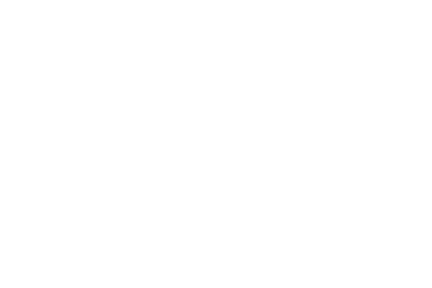

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


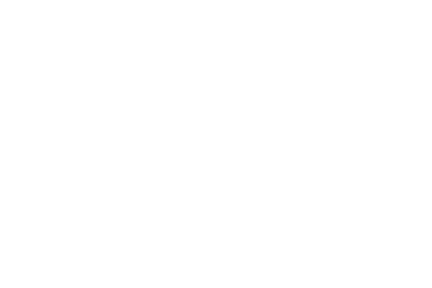

In [24]:
# JOAO - FIX - Automation WarmUp of Plot Library
import matplotlib.pyplot as plt
import time
plt.legend(loc = 'upper left')
fig= plt.figure()
ax= fig.add_subplot(111)
ax.set_xlim(0.5, 4.5)
plt.show()

In [25]:
%matplotlib notebook

<IPython.core.display.Javascript object>


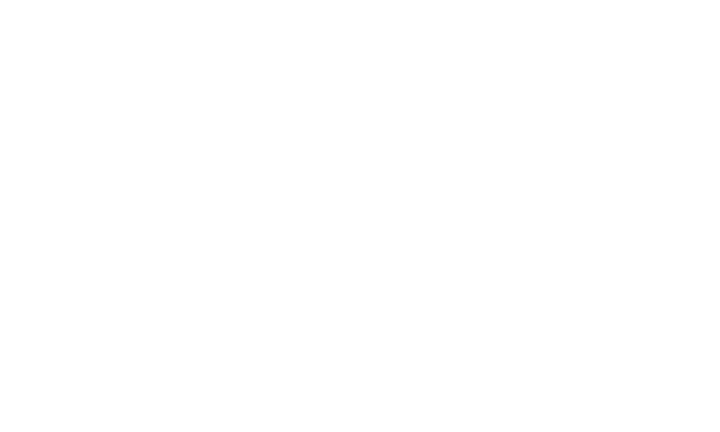

In [26]:
region='United States_nan'
eval_var='delta_aprox_14day_case_notification_rate_per_100k_hab'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,1]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(10,6),title ='Last 7 weeks Covid19 confirmed \"'+eval_var +'\" in '+region)
plt.legend(loc = 'upper left')
plt.show()

<IPython.core.display.Javascript object>


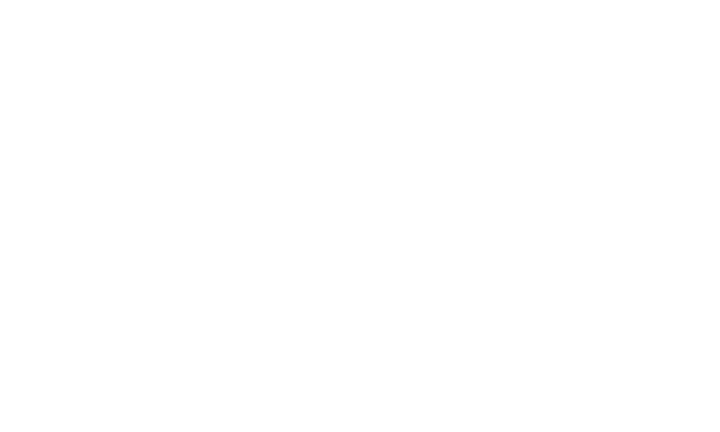

In [27]:
region='United Kingdom_nan'
eval_var='delta_aprox_14day_case_notification_rate_per_100k_hab'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,1]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(10,6),title ='Last 7 weeks Covid19 confirmed \"'+eval_var +'\" in '+region)
plt.legend(loc = 'upper left')
plt.show()

<IPython.core.display.Javascript object>


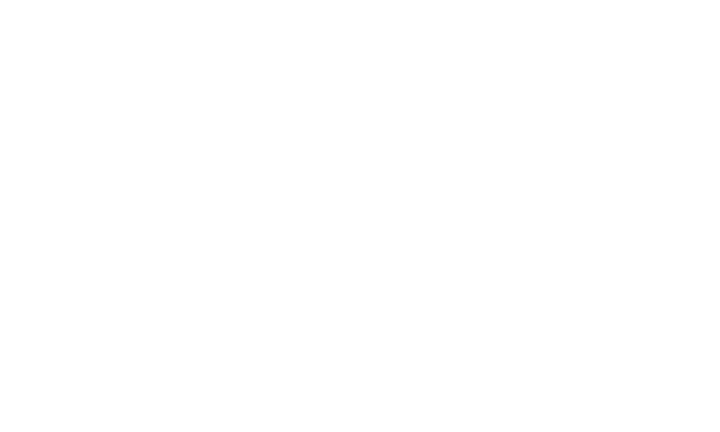

In [28]:
region='France_nan'
eval_var='delta_aprox_14day_case_notification_rate_per_100k_hab'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,1]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(10,6),title ='Last 7 weeks Covid19 confirmed \"'+eval_var +'\" in '+region)
plt.legend(loc = 'upper left')
plt.show()

<IPython.core.display.Javascript object>


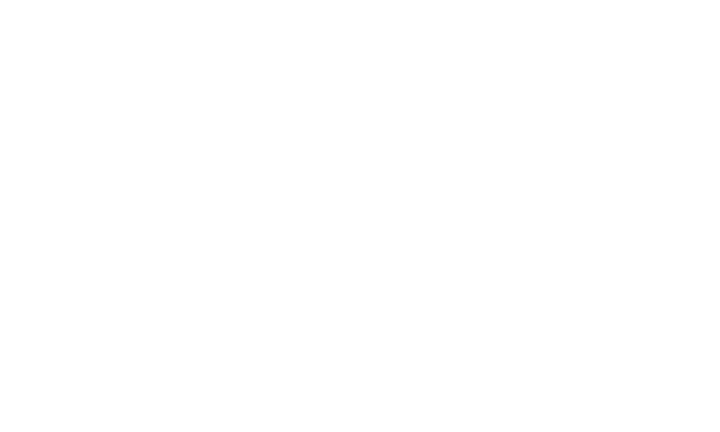

In [29]:
region='Spain_nan'
eval_var='delta_aprox_14day_case_notification_rate_per_100k_hab'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,1]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(10,6),title ='Last 7 weeks Covid19 confirmed \"'+eval_var +'\" in '+region)
plt.legend(loc = 'upper left')
plt.show()

<IPython.core.display.Javascript object>


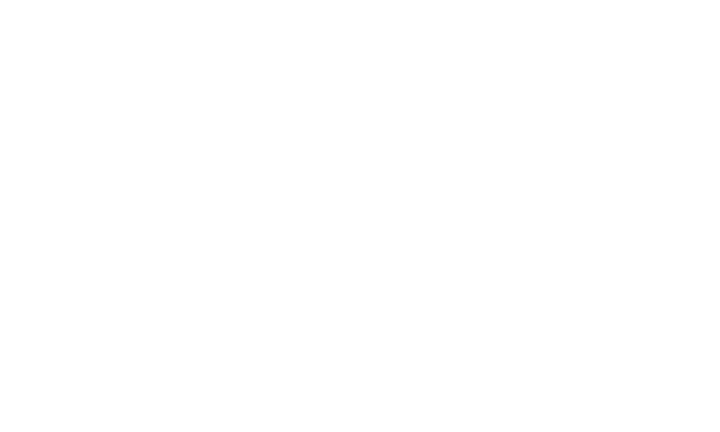

In [30]:
region='Italy_nan'
eval_var='delta_aprox_14day_case_notification_rate_per_100k_hab'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,1]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(10,6),title ='Last 7 weeks Covid19 confirmed \"'+eval_var +'\" in '+region)
plt.legend(loc = 'upper left')
plt.show()

<IPython.core.display.Javascript object>


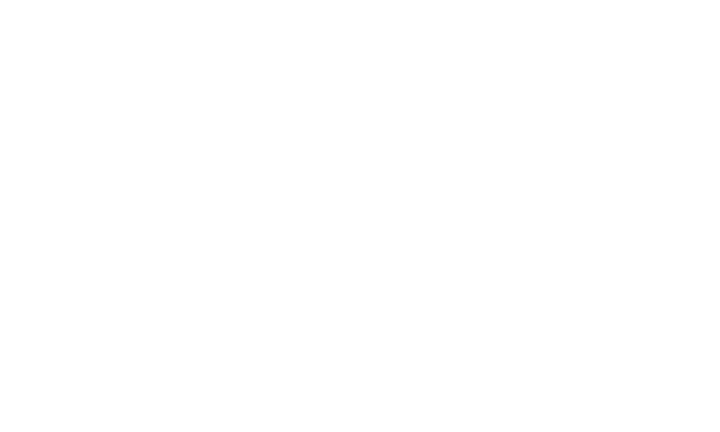

In [31]:
region='Germany_nan'
eval_var='delta_aprox_14day_case_notification_rate_per_100k_hab'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,1]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(10,6),title ='Last 7 weeks Covid19 confirmed \"'+eval_var +'\" in '+region)
plt.legend(loc = 'upper left')
plt.show()

<IPython.core.display.Javascript object>


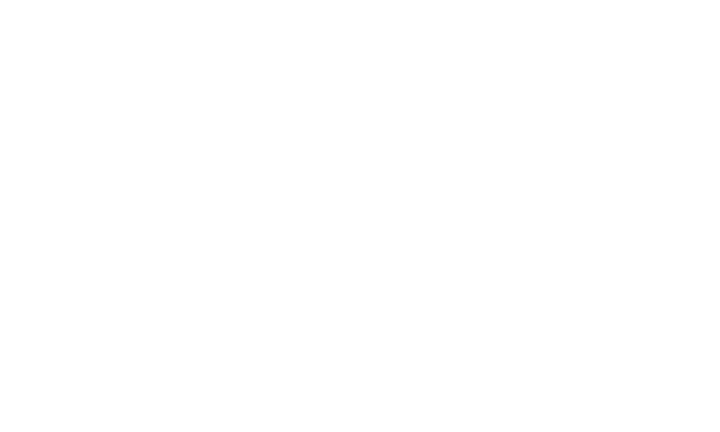

In [32]:
region='Switzerland_nan'
eval_var='delta_aprox_14day_case_notification_rate_per_100k_hab'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,1]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(10,6),title ='Last 7 weeks Covid19 confirmed \"'+eval_var +'\" in '+region)
plt.legend(loc = 'upper left')
plt.show()

<IPython.core.display.Javascript object>


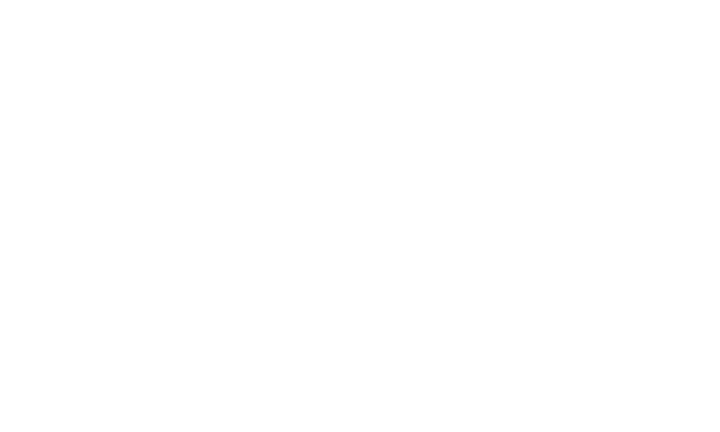

In [33]:
region='Belgium_nan'
eval_var='delta_aprox_14day_case_notification_rate_per_100k_hab'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,1]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(10,6),title ='Last 7 weeks Covid19 confirmed \"'+eval_var +'\" in '+region)
plt.legend(loc = 'upper left')
plt.show()

<IPython.core.display.Javascript object>


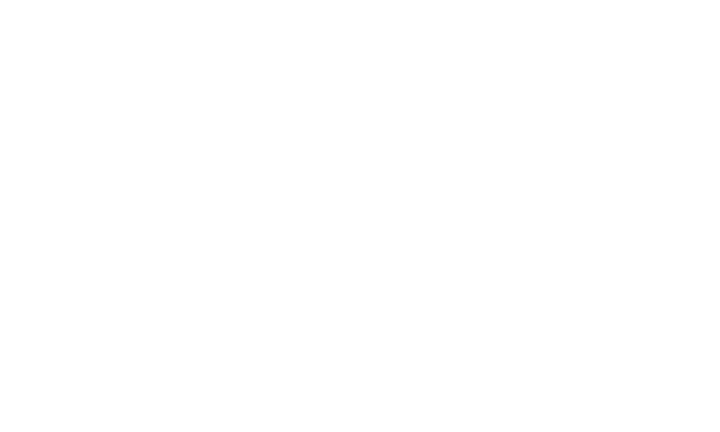

In [34]:
region='Netherlands_nan'
eval_var='delta_aprox_14day_case_notification_rate_per_100k_hab'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,1]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(10,6),title ='Last 7 weeks Covid19 confirmed \"'+eval_var +'\" in '+region)
plt.legend(loc = 'upper left')
plt.show()

<IPython.core.display.Javascript object>


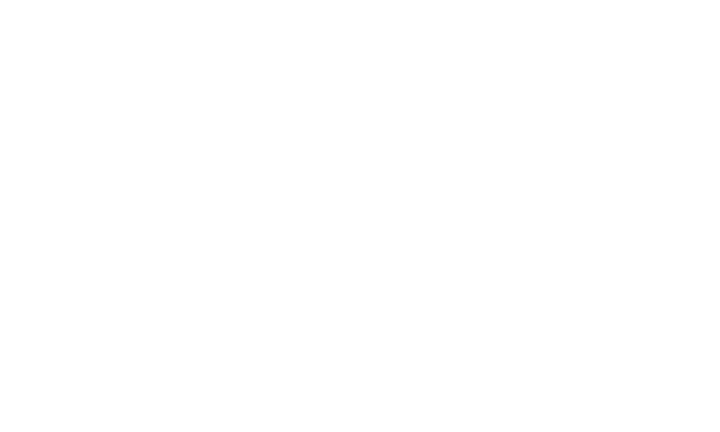

In [35]:
region='Czechia_nan'
eval_var='delta_aprox_14day_case_notification_rate_per_100k_hab'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,1]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(10,6),title ='Last 7 weeks Covid19 confirmed \"'+eval_var +'\" in '+region)
plt.legend(loc = 'upper left')
plt.show()

<IPython.core.display.Javascript object>


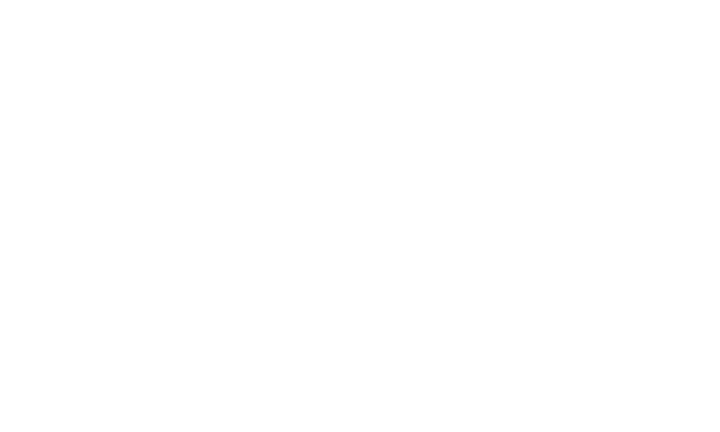

In [36]:
region='Portugal_nan'
eval_var='delta_aprox_14day_case_notification_rate_per_100k_hab'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,1]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(10,6),title ='Last 7 weeks Covid19 confirmed \"'+eval_var +'\" in '+region)
plt.legend(loc = 'upper left')
plt.show()

In [37]:
%matplotlib notebook
#%matplotlib inline

<IPython.core.display.Javascript object>


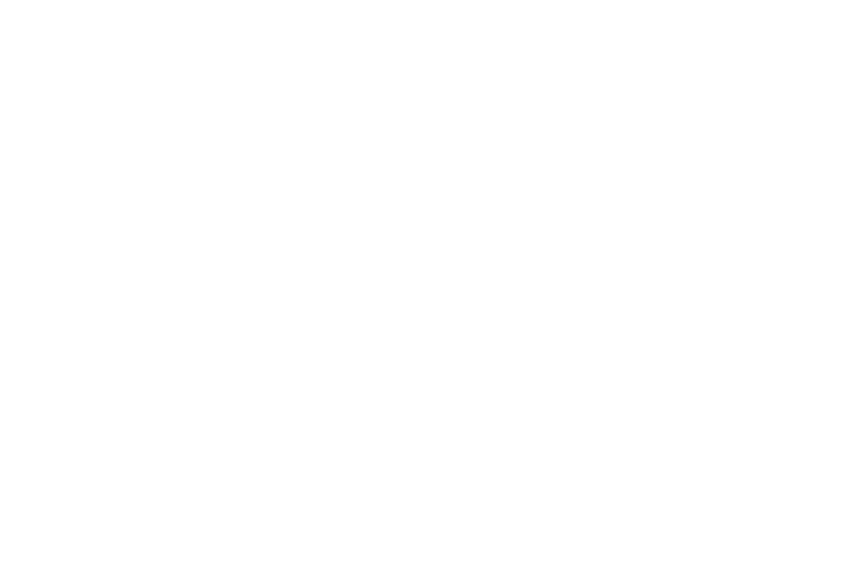

In [38]:
region='United States_nan'
eval_var='7_day_change'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,1]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(12,8),title ='Last 7 weeks Covid19 confirmed \"'+eval_var +'\" in '+region)
plt.legend(loc = 'upper left')
plt.show()

<IPython.core.display.Javascript object>


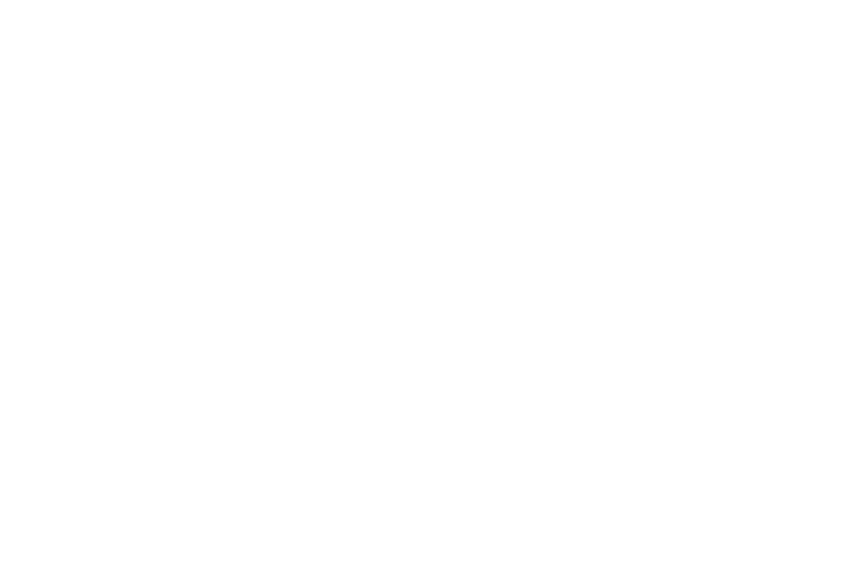

In [39]:
region='United Kingdom_nan'
eval_var='7_day_change'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,1]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(12,8),title ='Last 7 weeks Covid19 confirmed \"'+eval_var +'\" in '+region)
plt.legend(loc = 'upper left')
plt.show()

<IPython.core.display.Javascript object>


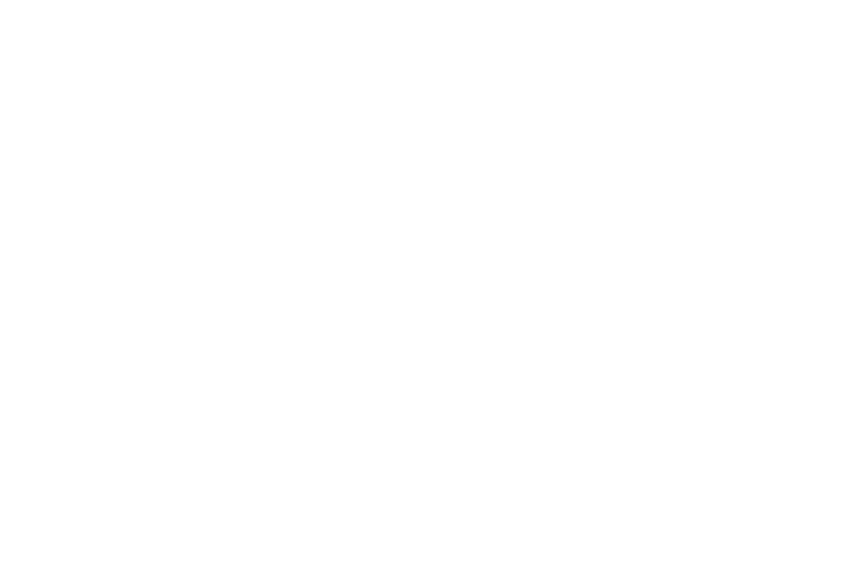

In [40]:
region='France_nan'
eval_var='7_day_change'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,1]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(12,8),title ='Last 7 weeks Covid19 confirmed \"'+eval_var +'\" in '+region)
plt.legend(loc = 'upper left')
plt.show()

<IPython.core.display.Javascript object>


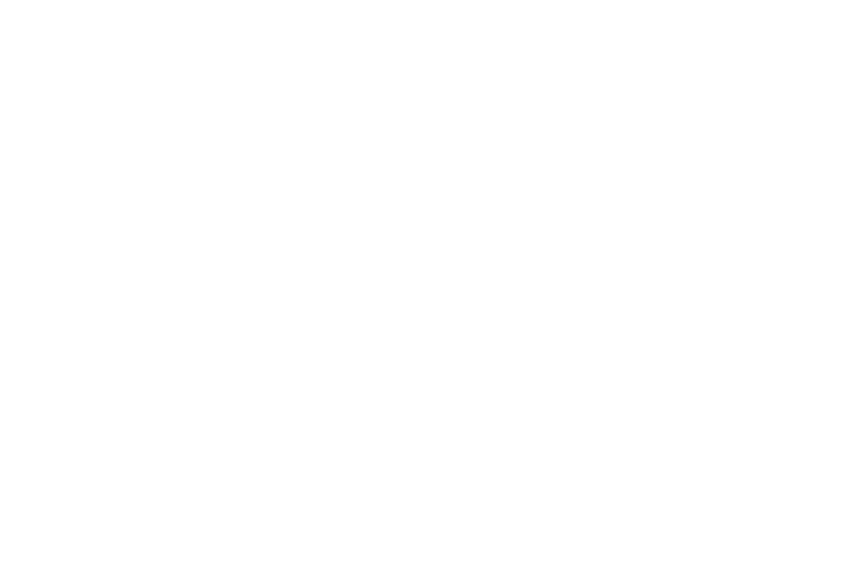

In [41]:
region='Spain_nan'
eval_var='7_day_change'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,1]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(12,8),title ='Last 7 weeks Covid19 confirmed \"'+eval_var +'\" in '+region)
plt.legend(loc = 'upper left')
plt.show()

<IPython.core.display.Javascript object>


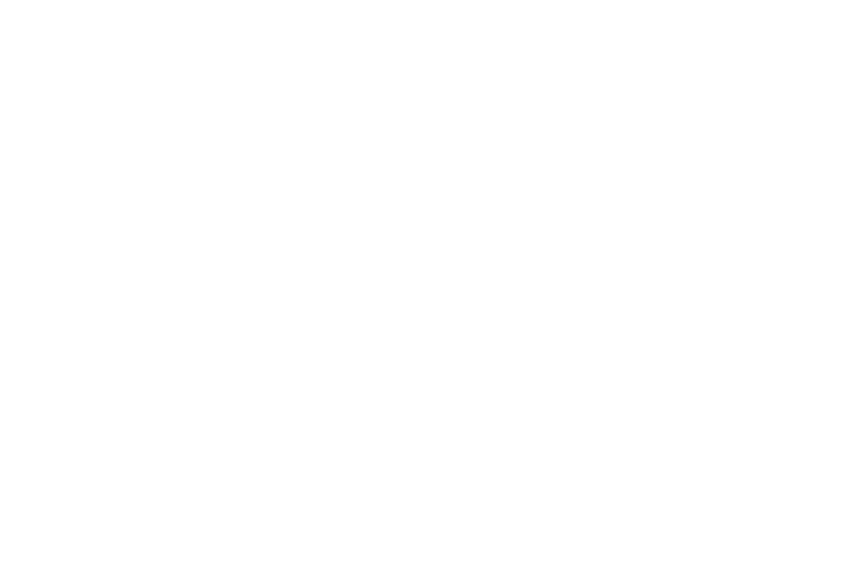

In [42]:
region='Italy_nan'
eval_var='7_day_change'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,1]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(12,8),title ='Last 7 weeks Covid19 confirmed \"'+eval_var +'\" in '+region)
plt.legend(loc = 'upper left')
plt.show()

<IPython.core.display.Javascript object>


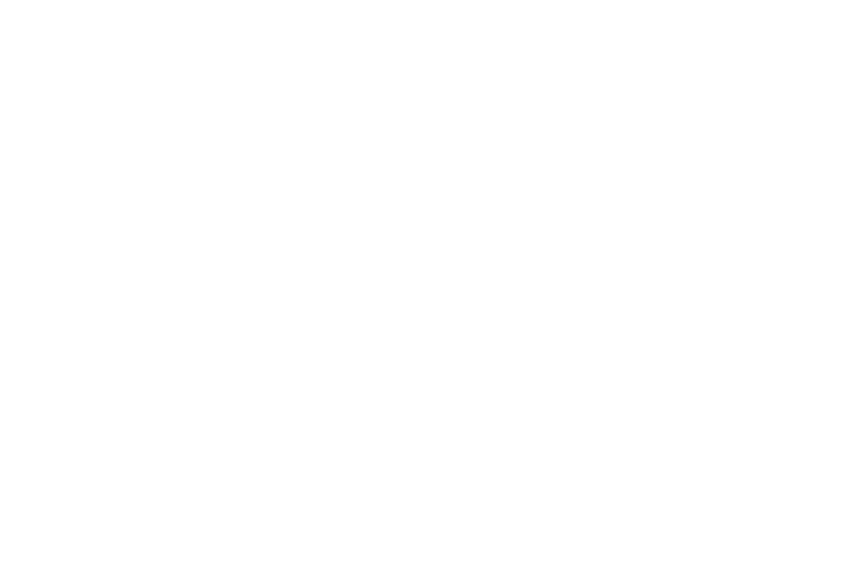

In [43]:
region='Germany_nan'
eval_var='7_day_change'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,1]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(12,8),title ='Last 7 weeks Covid19 confirmed \"'+eval_var +'\" in '+region)
plt.legend(loc = 'upper left')
plt.show()

<IPython.core.display.Javascript object>


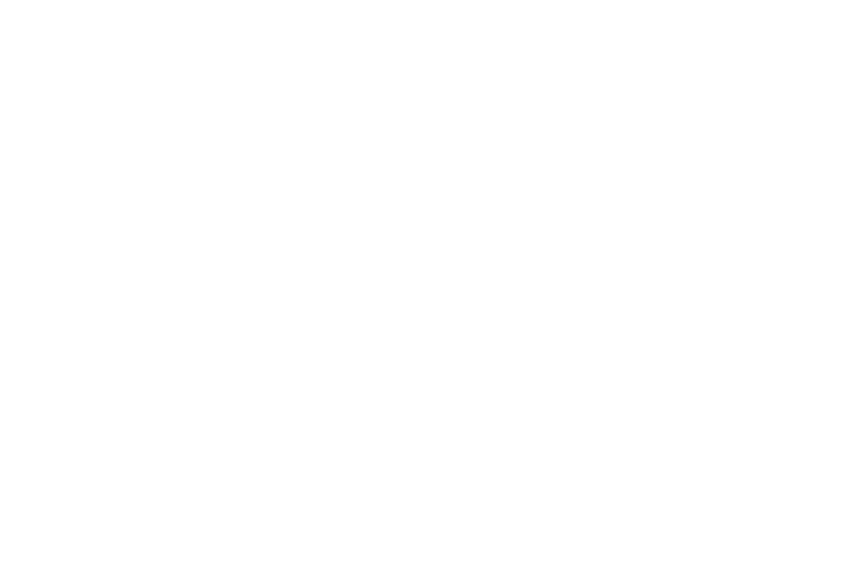

In [44]:
region='Netherlands_nan'
eval_var='7_day_change'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,1]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(12,8),title ='Last 7 weeks Covid19 confirmed \"'+eval_var +'\" in '+region)
plt.legend(loc = 'upper left')
plt.show()

<IPython.core.display.Javascript object>


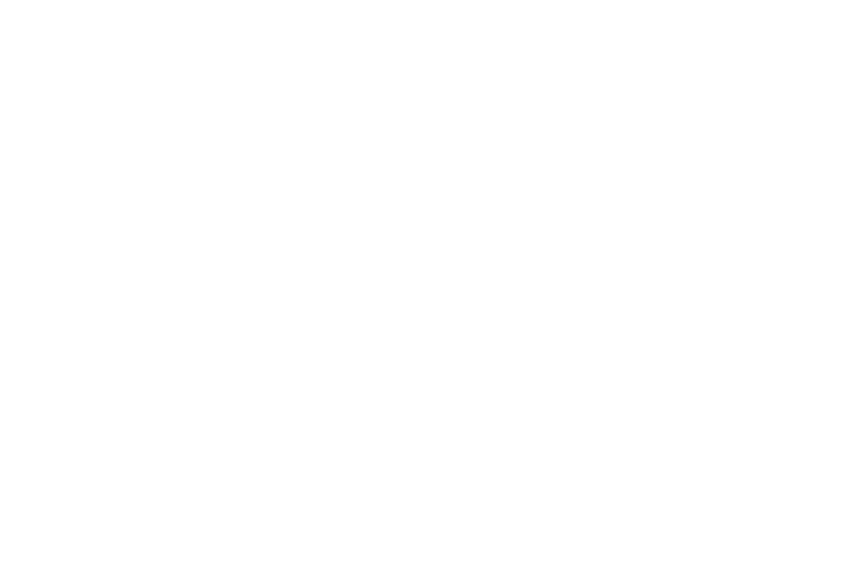

In [45]:
region='Belgium_nan'
eval_var='7_day_change'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,1]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(12,8),title ='Last 7 weeks Covid19 confirmed \"'+eval_var +'\" in '+region)
plt.legend(loc = 'upper left')
plt.show()

<IPython.core.display.Javascript object>


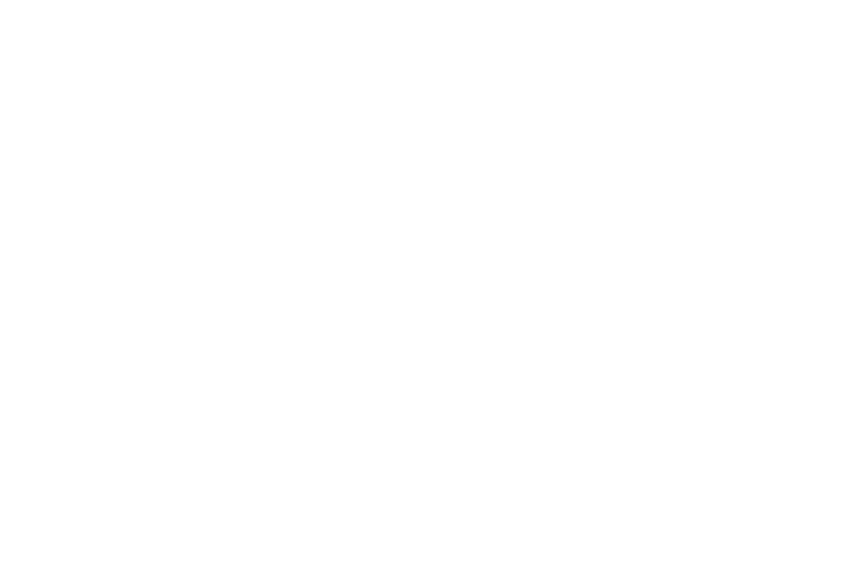

In [46]:
region='Czechia_nan'
eval_var='7_day_change'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,1]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(12,8),title ='Last 7 weeks Covid19 confirmed \"'+eval_var +'\" in '+region)
plt.legend(loc = 'upper left')
plt.show()

<IPython.core.display.Javascript object>


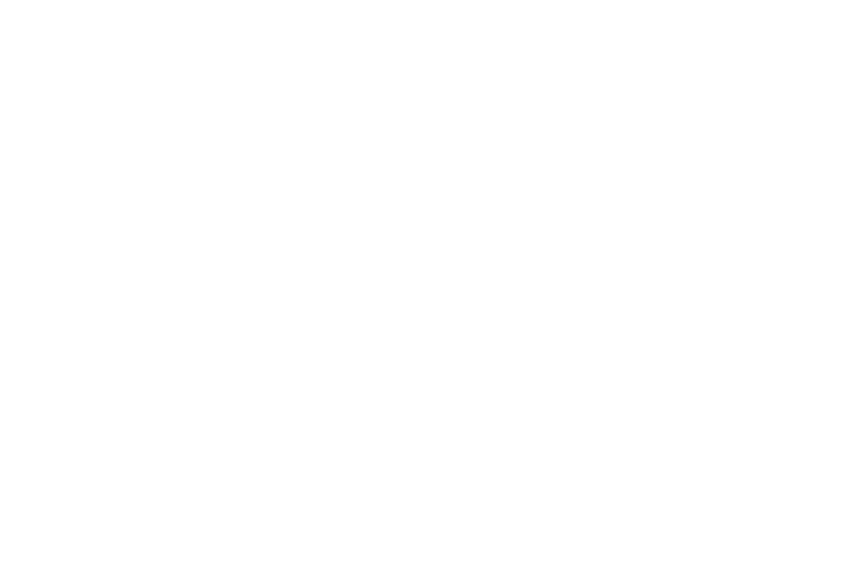

In [47]:
region='Portugal_nan'
eval_var='7_day_change'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,1]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(12,8),title ='Last 7 weeks Covid19 confirmed \"'+eval_var +'\" in '+region)
plt.legend(loc = 'upper left')
plt.show()

In [48]:
%matplotlib notebook
#%matplotlib inline

<IPython.core.display.Javascript object>


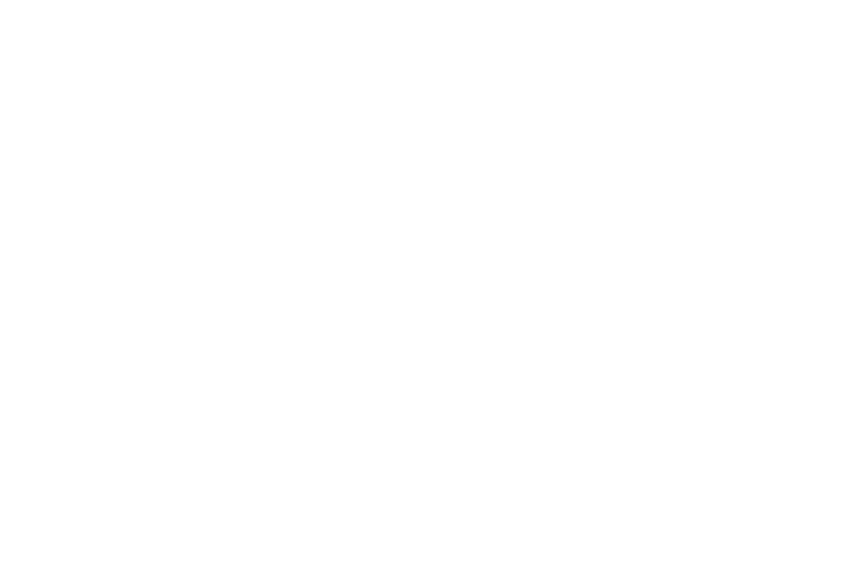

In [49]:
region='United States_nan'
eval_var='delta_roling_7day_AVG'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,1]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(12,8),title ='Last 7 weeks Covid19 confirmed \"'+eval_var +'\" in '+region)
plt.legend(loc = 'upper left')
plt.show()
plt.savefig("heatmaps/Daily-Covid19-Analysis-Spark-SQL-Delta.Lake_matplot.pyplot."+region+".png")

<IPython.core.display.Javascript object>


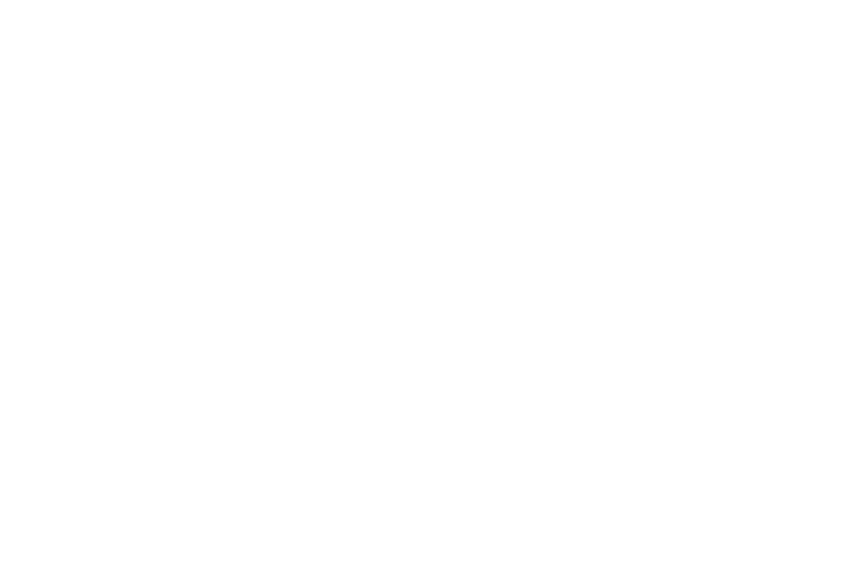

In [50]:
region='United Kingdom_nan'
eval_var='delta_roling_7day_AVG'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,1]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(12,8),title ='Last 7 weeks Covid19 confirmed \"'+eval_var +'\" in '+region)
plt.legend(loc = 'upper left')
plt.show()
plt.savefig("heatmaps/Daily-Covid19-Analysis-Spark-SQL-Delta.Lake_matplot.pyplot."+region+".png")

<IPython.core.display.Javascript object>


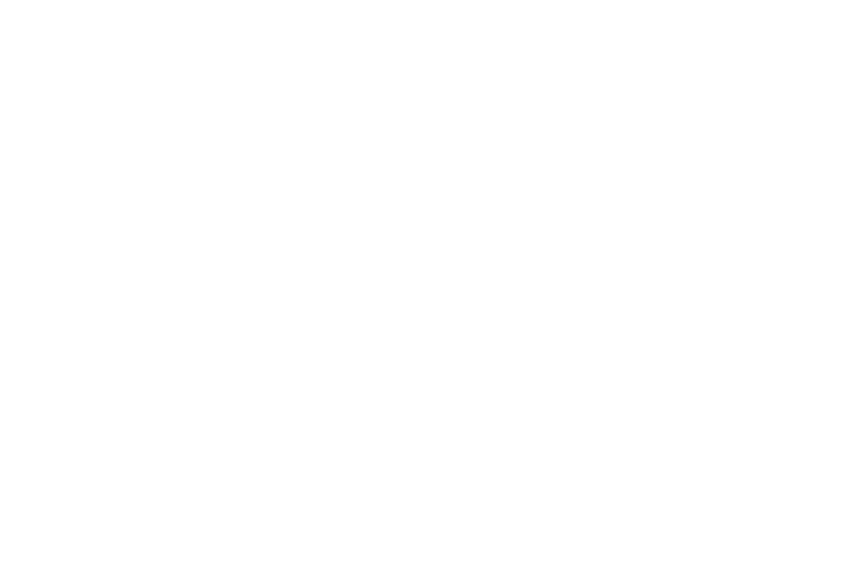

In [51]:
region='France_nan'
eval_var='delta_roling_7day_AVG'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,1]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(12,8),title ='Last 7 weeks Covid19 confirmed \"'+eval_var +'\" in '+region)
plt.legend(loc = 'upper left')
plt.show()
plt.savefig("heatmaps/Daily-Covid19-Analysis-Spark-SQL-Delta.Lake_matplot.pyplot."+region+".png")

<IPython.core.display.Javascript object>


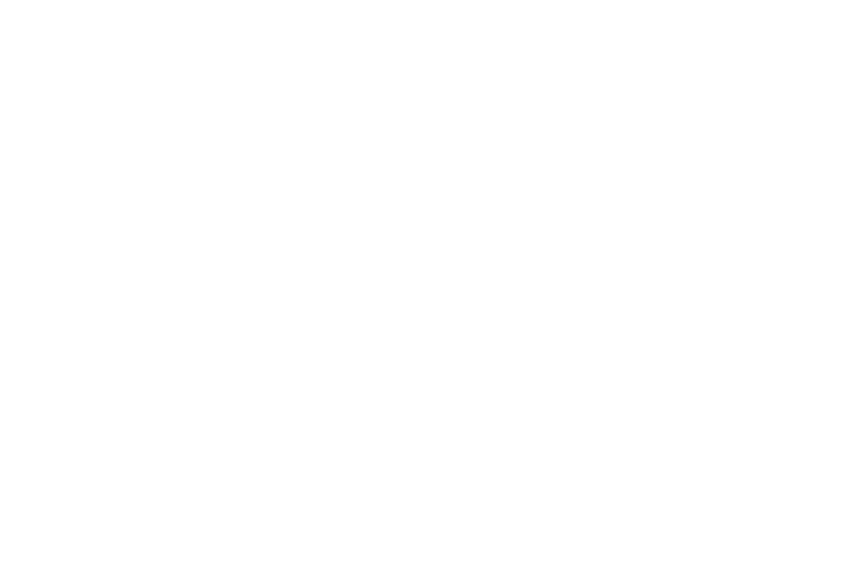

In [52]:
region='Spain_nan'
eval_var='delta_roling_7day_AVG'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,1]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(12,8),title ='Last 7 weeks Covid19 confirmed \"'+eval_var +'\" in '+region)
plt.legend(loc = 'upper left')
plt.show()
plt.savefig("heatmaps/Daily-Covid19-Analysis-Spark-SQL-Delta.Lake_matplot.pyplot."+region+".png")

<IPython.core.display.Javascript object>


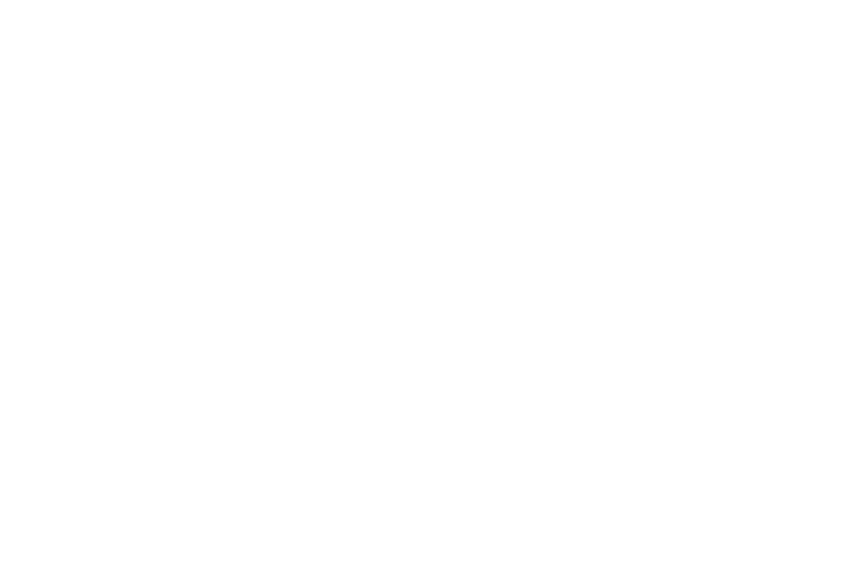

In [53]:
region='Italy_nan'
eval_var='delta_roling_7day_AVG'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,1]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(12,8),title ='Last 7 weeks Covid19 confirmed \"'+eval_var +'\" in '+region)
plt.legend(loc = 'upper left')
plt.show()
plt.savefig("heatmaps/Daily-Covid19-Analysis-Spark-SQL-Delta.Lake_matplot.pyplot."+region+".png")

<IPython.core.display.Javascript object>


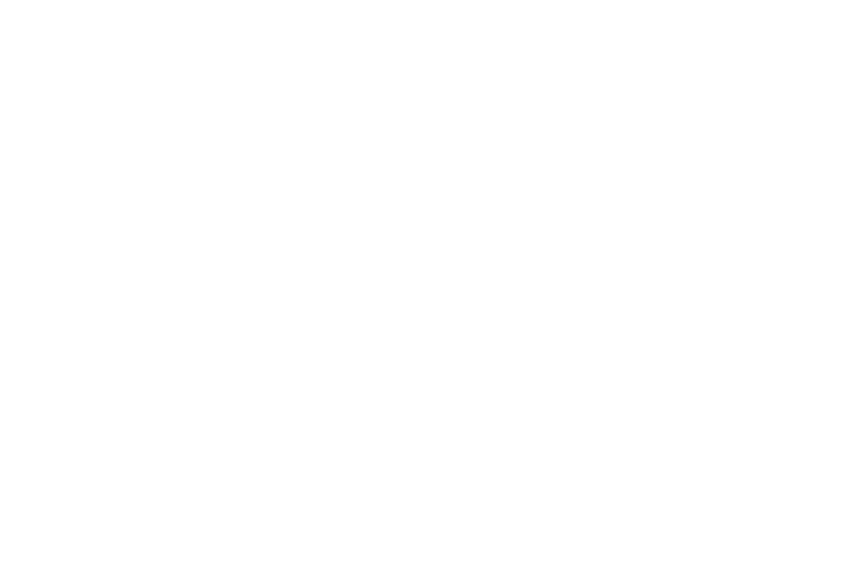

In [54]:
region='Germany_nan'
eval_var='delta_roling_7day_AVG'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,1]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(12,8),title ='Last 7 weeks Covid19 confirmed \"'+eval_var +'\" in '+region)
plt.legend(loc = 'upper left')
plt.show()
plt.savefig("heatmaps/Daily-Covid19-Analysis-Spark-SQL-Delta.Lake_matplot.pyplot."+region+".png")

<IPython.core.display.Javascript object>


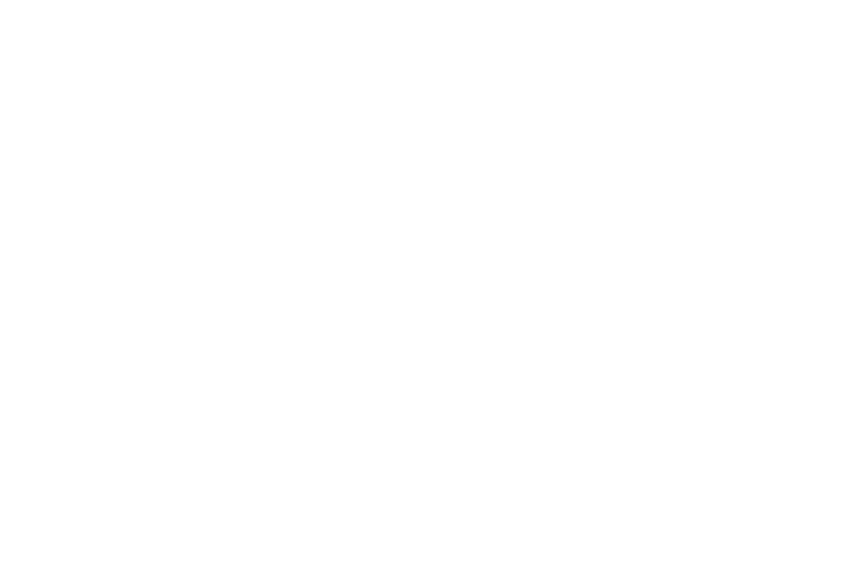

In [55]:
region='Switzerland_nan'
eval_var='delta_roling_7day_AVG'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,1]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(12,8),title ='Last 7 weeks Covid19 confirmed \"'+eval_var +'\" in '+region)
plt.legend(loc = 'upper left')
plt.show()
plt.savefig("heatmaps/Daily-Covid19-Analysis-Spark-SQL-Delta.Lake_matplot.pyplot."+region+".png")

<IPython.core.display.Javascript object>


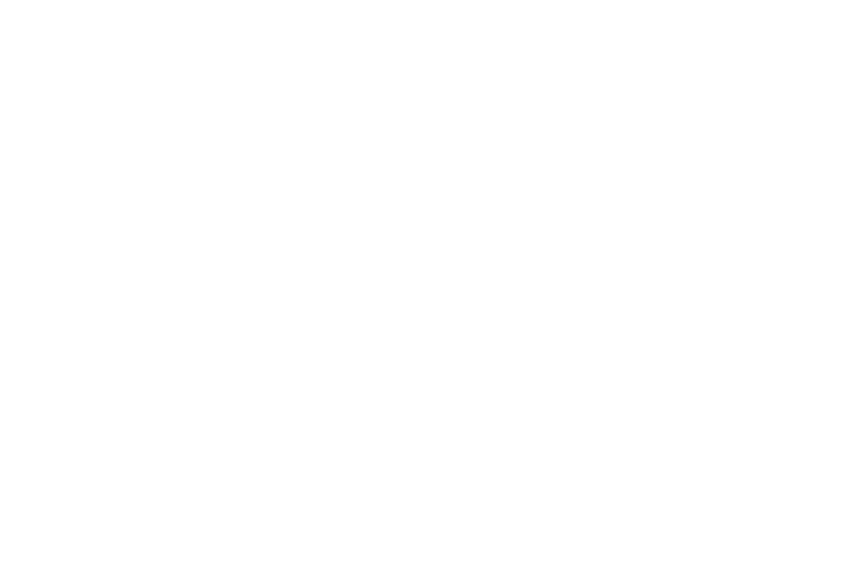

In [56]:
region='Belgium_nan'
eval_var='delta_roling_7day_AVG'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,1]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(12,8),title ='Last 7 weeks Covid19 confirmed \"'+eval_var +'\" in '+region)
plt.legend(loc = 'upper left')
plt.show()
plt.savefig("heatmaps/Daily-Covid19-Analysis-Spark-SQL-Delta.Lake_matplot.pyplot."+region+".png")

<IPython.core.display.Javascript object>


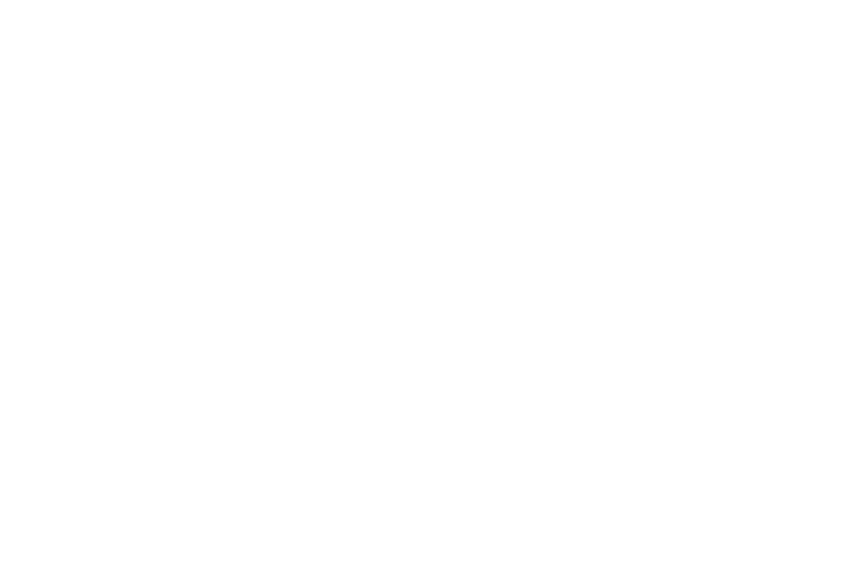

In [57]:
region='Netherlands_nan'
eval_var='delta_roling_7day_AVG'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,1]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(12,8),title ='Last 7 weeks Covid19 confirmed \"'+eval_var +'\" in '+region)
plt.legend(loc = 'upper left')
plt.show()
plt.savefig("heatmaps/Daily-Covid19-Analysis-Spark-SQL-Delta.Lake_matplot.pyplot."+region+".png")

<IPython.core.display.Javascript object>


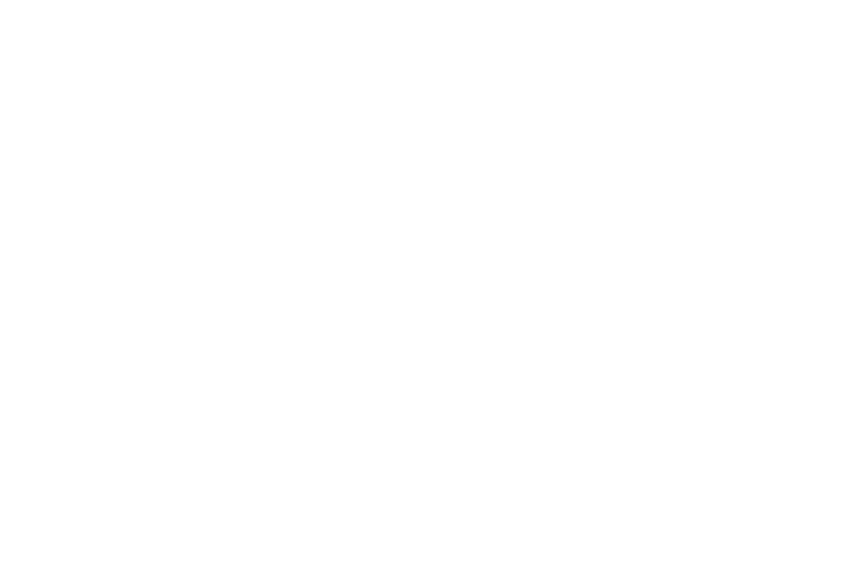

In [58]:
region='Czechia_nan'
eval_var='delta_roling_7day_AVG'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,1]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(12,8),title ='Last 7 weeks Covid19 confirmed \"'+eval_var +'\" in '+region)
plt.legend(loc = 'upper left')
plt.show()
plt.savefig("heatmaps/Daily-Covid19-Analysis-Spark-SQL-Delta.Lake_matplot.pyplot."+region+".png")

<IPython.core.display.Javascript object>


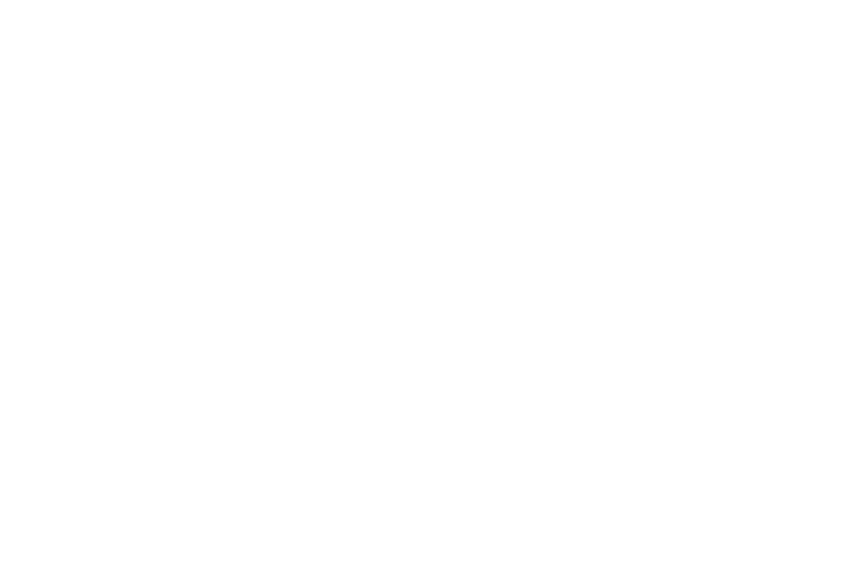

In [59]:
region='Portugal_nan'
eval_var='delta_roling_7day_AVG'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,1]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(12,8),title ='Last 7 weeks Covid19 confirmed \"'+eval_var +'\" in '+region)
plt.legend(loc = 'upper left')
plt.show()
plt.savefig("heatmaps/Daily-Covid19-Analysis-Spark-SQL-Delta.Lake_matplot.pyplot."+region+".png")

In [60]:
print("Validation analysis for 1day-Forecast and display purpose in https://FuelBigData.com/blog is done!")

Validation analysis for 1day-Forecast and display purpose in https://FuelBigData.com/blog is done!


In [61]:
exit()